In [1]:
from utils import cc, pcc, ols_adj, bootstrap
import pandas as pd
import numpy as np
import sys

# latex vs. jupyter notebook formatting
form = lambda x: "{:.1f}".format((round(100 * x, 1))) + "%"
full_form = lambda x: form(x[0]) + r' (' + form(x[1]) + "," + form(x[2]) + ")"
# form = lambda x: "{:.1f}".format((round(100 * x, 1))) + "\%"
# full_form = lambda x: form(x[0]) + r'\conf{' + form(x[1]) + "}{" + form(x[2]) + "}" latex version

# Loads data

In [2]:
df_study_1 = pd.read_csv("../data/Study-1-augmented.csv.gz")
df_test = pd.read_csv("../data/Test-set-model.csv.gz")

# Prevalence estimates

In [3]:
df_prev = pd.DataFrame([
    {
        "": "Prolific",
        "CC": full_form(bootstrap(cc, df_study_1)),
        "PCC": full_form(bootstrap(pcc, df_study_1)),
        "Adj": full_form(bootstrap(ols_adj, df_study_1, df_test))
    }
])

df_prev

,,CC,PCC,Adj
0,Prolific,"34.8% (27.3%,42.2%)","36.1% (30.7%,41.8%)","35.4% (27.8%,43.0%)"


# Copying patterns

In [4]:
copy_df = df_study_1.groupby(
    ["copied", "y_cc"]).key_strokes.count()\
    .reset_index().pivot(columns="y_cc", index="copied", values="key_strokes").fillna(0)
copy_df
# 47/(39+47) ~ 55% copied     classified synthetic.
#  8/(64+8)  ~ 11% not copied classified synthetic.

y_cc,real,synthetic
copied,,
0.0,64,8
1.0,39,47


# Proportion copied

In [5]:
from string2string.alignment import LongestCommonSubsequence, LongestCommonSubstring
from string2string.misc.default_tokenizer import Tokenizer

def measure_substr_length(gen, k):
    lcsubsequence = LongestCommonSubstring()
    tokenizer = Tokenizer(word_delimiter=' ')
    gen_token = tokenizer.tokenize(gen)
    k_token = tokenizer.tokenize(k)
    
    
    length, candidates = lcsubsequence.compute(
        str1=gen_token,
        str2=k_token,
        returnCandidates=False,
    )
    return length 

def get_proportion_copied(df_v):
    copied = df_v
    common_substr = []
    for i, row in copied.iterrows():
        common_substr.append(measure_substr_length(row["original_text"], row["text"]))
        
    copied["common_substr"] = common_substr
    
    tokenizer = Tokenizer(word_delimiter=' ')
    
    copied["original_length"] = copied["original_text"].apply(lambda x: len(tokenizer.tokenize(x)))
    copied["text_length"] = copied["text"].apply(lambda x: len(tokenizer.tokenize(x)))
    
    copied["prop_copied"] = copied["common_substr"] / copied["text_length"]
    
get_proportion_copied(df_study_1)

In [6]:
import matplotlib.pyplot as plt

def make_plot_copied(proportion_copied, fig, ax):
    # Create bins for 'prop_copied' values
    bins = np.linspace(proportion_copied["prop_copied"].min(), proportion_copied["prop_copied"].max(), 11)
    
    # Cut 'prop_copied' into bins and count the n
    # bins = np.arange(0.1, 1.1, 0.1)
    
    real_data = proportion_copied[proportion_copied["y_cc"] == "real"]\
        ["prop_copied"].groupby(pd.cut(proportion_copied[proportion_copied["y_cc"] == "real"]\
        ["prop_copied"], bins, labels=False)).count()
    synthetic_data = proportion_copied[proportion_copied["y_cc"] == "synthetic"]\
        ["prop_copied"].groupby(pd.cut(proportion_copied[proportion_copied["y_cc"] == "synthetic"]\
        ["prop_copied"], bins, labels=False)).count()
    
    real_data.fillna(0, inplace=True)
    synthetic_data.fillna(0, inplace=True)
    
    concatted = pd.concat([real_data, synthetic_data], axis=1).fillna(0)
    concatted.columns = ["real", "synthetic"]
    concatted = concatted.sort_index()
    concatted.index = np.round(concatted.index / 10 + .1, 1)
        
    # Set bar width
    bar_width = 0.45
    
    # Create two arrays for the positions of the bars on the x-axis
    r1 = np.arange(len(concatted["real"]))
    r2 = [x + bar_width for x in r1]
    
    # Plot 'real' data
    ax.bar(r1, concatted["real"], color='#44a5c2', width=bar_width, edgecolor="black", label='classified as real')
    
    # Plot 'synthetic' data
    ax.bar(np.array(r2)-bar_width*2, concatted["synthetic"], color='#ffae49', width=bar_width,
           edgecolor="black", label='classified as synthetic')
    
    # Label the x-axis with the categories
    ax.set_xticks([r + bar_width / 2 for r in range(len(concatted["real"]))])
    ax.set_xticklabels(concatted.index.astype(str))
        
    ax.set_ylabel("Count", fontsize=16)
    ax.set_xlabel("Proportion copied from abstract", fontsize=16)
    ax.tick_params(labelsize=14)
    ax.spines[['right', 'top']].set_visible(False)
    ax.legend(frameon=False, fontsize=13)

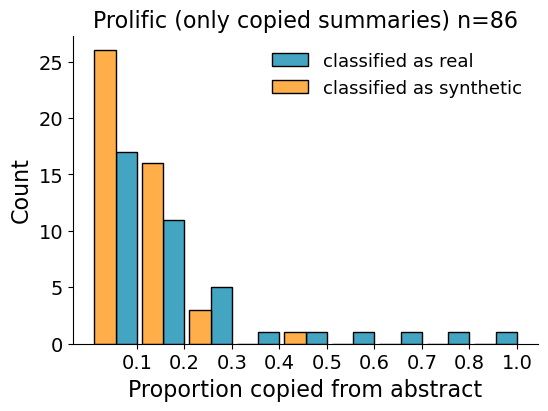

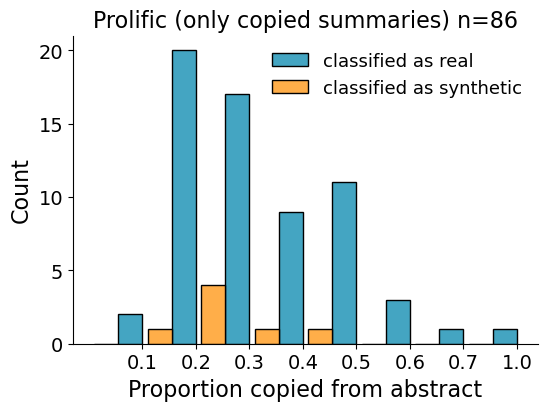

In [7]:
fig, ax = plt.subplots(figsize=(6,4))
make_plot_copied(df_study_1[(df_study_1.copied == True)], fig, ax)
ax.set_title("Prolific (only copied summaries) n=" + 
             str(round(len(df_study_1[(df_study_1.copied == True)]))), size=16)
plt.savefig("./imgs/proportion_copied_side_by_side_prolific_copy.pdf", dpi=300, bbox_inches="tight")


fig, ax = plt.subplots(figsize=(6,4))
make_plot_copied(df_study_1[(df_study_1.copied == False)], fig, ax)
ax.set_title("Prolific (only copied summaries) n=" + 
             str(round(len(df_study_1[(df_study_1.copied == True)]))), size=16)
plt.savefig("./imgs/proportion_copied_side_by_side_prolific_not_copy.pdf", dpi=300, bbox_inches="tight")
